In [26]:
from PIL import Image
import numpy as np
import os
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import random
from math import log
from tqdm import tqdm

Encryption

In [27]:
def LogisticEncryption(imageName, key):
    N = 256
    key_list = [ord(x) for x in key]
    G = [key_list[0:4] ,key_list[4:8], key_list[8:12]]
    g = []
    R = 1
    for i in range(1,4):
        s = 0
        for j in range(1,5):
            s += G[i-1][j-1] * (10**(-j))
        g.append(s)
        R = (R*s) % 1

    L = (R + key_list[12]/256) % 1
    S_x = round(((g[0]+g[1]+g[2])*(10**4) + L *(10**4)) % 256)
    V1 = sum(key_list)
    V2 = key_list[0]
    for i in range(1,13):
        V2 = V2 ^ key_list[i]
    V = V2/V1

    L_y = (V+key_list[12]/256) % 1
    S_y = round((V+V2+L_y*10**4) % 256)
    C1_0 = S_x
    C2_0 = S_y
    C = round((L*L_y*10**4) % 256)
    C_r = round((L*L_y*10**4) % 256)
    C_g = round((L*L_y*10**4) % 256)
    C_b = round((L*L_y*10**4) % 256)
    x = 4*(S_x)*(1-S_x)
    y = 4*(S_y)*(1-S_y)

    imageMatrix,dimensionX, dimensionY, color = getImageMatrix(imageName)
    LogisticEncryptionIm = []
    for i in range(dimensionX):
        row = []
        for j in range(dimensionY):
            while x <0.8 and x > 0.2 :
                x = 4*x*(1-x)
            while y <0.8 and y > 0.2 :
                y = 4*y*(1-y)
            x_round = round((x*(10**4))%256)
            y_round = round((y*(10**4))%256)
            C1 = x_round ^ ((key_list[0]+x_round) % N) ^ ((C1_0 + key_list[1])%N)
            C2 = x_round ^ ((key_list[2]+y_round) % N) ^ ((C2_0 + key_list[3])%N)
            if color:
              C_r =((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((key_list[6]+imageMatrix[i][j][0]) % N) ^ ((C_r + key_list[7]) % N)
              C_g =((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((key_list[6]+imageMatrix[i][j][1]) % N) ^ ((C_g + key_list[7]) % N)
              C_b =((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((key_list[6]+imageMatrix[i][j][2]) % N) ^ ((C_b + key_list[7]) % N)
              row.append((C_r,C_g,C_b))
              C = C_r

            else:
              C = ((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((key_list[6]+imageMatrix[i][j]) % N) ^ ((C + key_list[7]) % N)
              row.append(C)

            x = (x + C/256 + key_list[8]/256 + key_list[9]/256) % 1
            y = (x + C/256 + key_list[8]/256 + key_list[9]/256) % 1
            for ki in range(12):
                key_list[ki] = (key_list[ki] + key_list[12]) % 256
                key_list[12] = key_list[12] ^ key_list[ki]
        LogisticEncryptionIm.append(row)

    im = Image.new("L", (dimensionX, dimensionY))
    if color:
        im = Image.new("RGB", (dimensionX, dimensionY))
    else:
        im = Image.new("L", (dimensionX, dimensionY)) # L is for Black and white pixels

    pix = im.load()
    for x in range(dimensionX):
        for y in range(dimensionY):
            pix[x, y] = LogisticEncryptionIm[x][y]
    im.save(imageName.split('.')[0] + "_LogisticEnc.png", "PNG")

In [28]:
def getImageMatrix(imageName):
    im = Image.open(imageName)
    pix = im.load()
    color = 1
    if type(pix[0,0]) == int:
      color = 0
    image_size = im.size
    image_matrix = []
    for width in range(int(image_size[0])):
        row = []
        for height in range(int(image_size[1])):
                row.append((pix[width,height]))
        image_matrix.append(row)
    return image_matrix, image_size[0], image_size[1],color

In [29]:
image = "photo3"
ext = ".png"
image_path = image + ext
key_logistic = "abcdefghijklm"

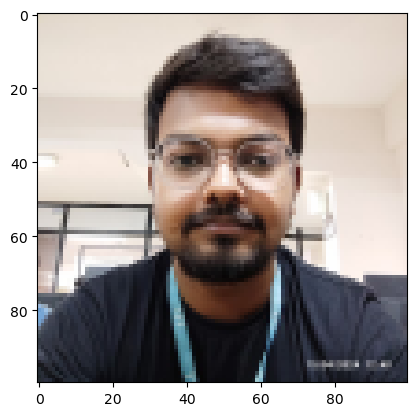

In [30]:
pil_im = Image.open(image_path, 'r')
imshow(np.asarray(pil_im), cmap='gray')

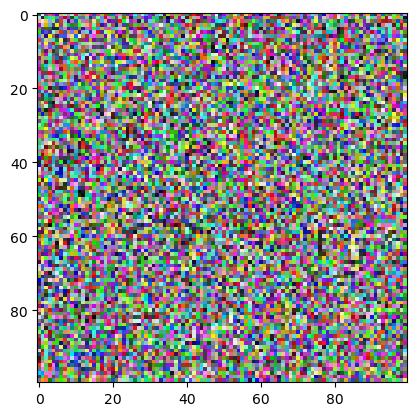

In [31]:
LogisticEncryption(image_path, key_logistic)
im = Image.open(image_path.split('.')[0] + "_LogisticEnc.png", 'r')
imshow(np.asarray(im), cmap='gray')

In [32]:
def genData(data):
    data_str = str(data)
    newd = [format(ord(char), '08b') for char in data_str]
    return newd


def modPix(pix, data):

	datalist = genData(data)
	lendata = len(datalist)
	imdata = iter(pix)

	for i in range(lendata):

		pix = [value for value in imdata.__next__()[:3] +
								imdata.__next__()[:3] +
								imdata.__next__()[:3]]


		for j in range(0, 8):
			if (datalist[i][j] == '0' and pix[j]% 2 != 0):
				pix[j] -= 1

			elif (datalist[i][j] == '1' and pix[j] % 2 == 0):
				if(pix[j] != 0):
					pix[j] -= 1
				else:
					pix[j] += 1

		if (i == lendata - 1):
			if (pix[-1] % 2 == 0):
				if(pix[-1] != 0):
					pix[-1] -= 1
				else:
					pix[-1] += 1

		else:
			if (pix[-1] % 2 != 0):
				pix[-1] -= 1

		pix = tuple(pix)
		yield pix[0:3]
		yield pix[3:6]
		yield pix[6:9]

In [33]:
def dec(bitSequence):
    decimal = 0
    for bit in bitSequence:
        decimal = decimal * 2 + int(bit)
    return decimal

In [34]:
def genHenonMap(dimension, key):
    x = key[0]
    y = key[1]
    sequenceSize = dimension * dimension * 8 #Total Number of bitSequence produced
    bitSequence = []    #Each bitSequence contains 8 bits
    byteArray = []      #Each byteArray contains m( i.e 512 in this case) bitSequence
    TImageMatrix = []   #Each TImageMatrix contains m*n byteArray( i.e 512 byteArray in this case)
    for i in range(sequenceSize):
        xN = y + 1 - 1.4 * x**2
        yN = 0.3 * x

        x = xN
        y = yN

        if xN <= 0.4:
            bit = 0
        else:
            bit = 1

        try:
            bitSequence.append(bit)
        except:
            bitSequence = [bit]

        if i % 8 == 7:
            decimal = dec(bitSequence)
            try:
                byteArray.append(decimal)
            except:
                byteArray = [decimal]
            bitSequence = []

        byteArraySize = dimension*8
        if i % byteArraySize == byteArraySize-1:
            try:
                TImageMatrix.append(byteArray)
            except:
                TImageMatrix = [byteArray]
            byteArray = []
    return TImageMatrix

In [35]:
def HenonEncryption(imageName,key):
    imageMatrix, dimensionX, dimensionY, color = getImageMatrix(imageName)
    transformationMatrix = genHenonMap(dimensionX, key)
    resultantMatrix = []
    for i in range(dimensionX):
        row = []
        for j in range(dimensionY):
            try:
                if color:
                    row.append(tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]))
                else:
                    row.append(transformationMatrix[i][j] ^ imageMatrix[i][j])
            except:
                if color:
                    row = [tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]])]
                else :
                    row = [transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]
        try:
            resultantMatrix.append(row)
        except:
            resultantMatrix = [row]
    if color:
      im = Image.new("RGB", (dimensionX, dimensionY))
    else:
      im = Image.new("L", (dimensionX, dimensionY)) # L is for Black and white pixels

    pix = im.load()
    for x in range(dimensionX):
        for y in range(dimensionY):
            pix[x, y] = resultantMatrix[x][y]
    im.save(imageName.split('.')[0] + "_HenonEnc.png", "PNG")

In [36]:
image = image + "_LogisticEnc"
ext = ".png"
image_path = image + ext
key_henon = (0.1,0.1)

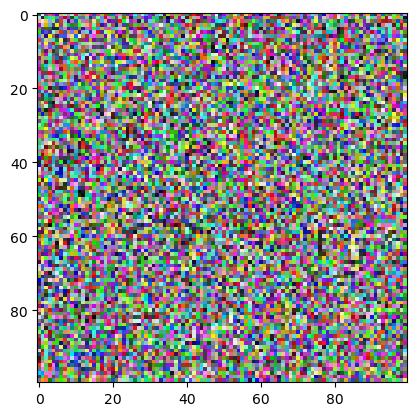

In [37]:
pil_im = Image.open(image_path, 'r')
imshow(np.asarray(pil_im))

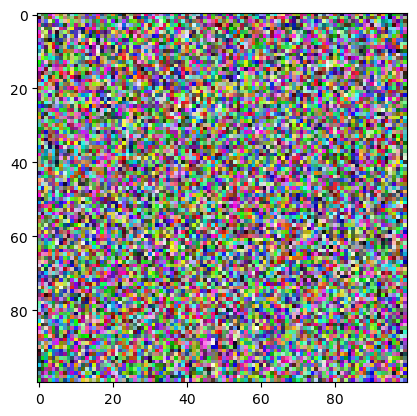

In [38]:
HenonEncryption(image_path, key_henon)
im = Image.open(image + "_HenonEnc.png", 'r')
imshow(np.asarray(im))

In [39]:
image = image +  "_HenonEnc"
ext = ".png"
image_path = image + ext

In [40]:
def HenonDecryption(imageNameEnc, key):
    imageMatrix, dimensionX, dimensionY, color = getImageMatrix(imageNameEnc)
    transformationMatrix = genHenonMap(dimensionX, key)
    pil_im = Image.open(imageNameEnc, 'r')
    imshow(np.asarray(pil_im))
    henonDecryptedImage = []
    for i in range(dimensionX):
        row = []
        for j in range(dimensionY):
            try:
                if color:
                    row.append(tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]))
                else:
                    row.append(transformationMatrix[i][j] ^ imageMatrix[i][j])
            except:
                if color:
                    row = [tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]])]
                else :
                    row = [transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]
        try:
            henonDecryptedImage.append(row)
        except:
            henonDecryptedImage = [row]
    if color:
        im = Image.new("RGB", (dimensionX, dimensionY))
    else:
        im = Image.new("L", (dimensionX, dimensionY)) # L is for Black and white pixels

    pix = im.load()
    for x in range(dimensionX):
        for y in range(dimensionY):
            pix[x, y] = henonDecryptedImage[x][y]
    im.save(imageNameEnc.split('.')[0] + "_HenonDec.png", "PNG")

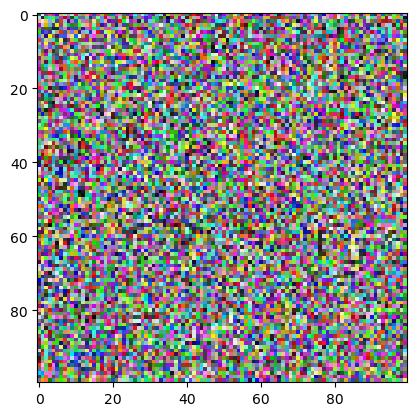

In [41]:
HenonDecryption(image_path, key_henon)
im = Image.open(image + "_HenonDec.png", 'r')
imshow(np.asarray(im))

In [42]:
def LogisticDecryption(imageName, key):
    N = 256
    key_list = [ord(x) for x in key]

    G = [key_list[0:4] ,key_list[4:8], key_list[8:12]]
    g = []
    R = 1
    for i in range(1,4):
        s = 0
        for j in range(1,5):
            s += G[i-1][j-1] * (10**(-j))
        g.append(s)
        R = (R*s) % 1

    L_x = (R + key_list[12]/256) % 1
    S_x = round(((g[0]+g[1]+g[2])*(10**4) + L_x *(10**4)) % 256)
    V1 = sum(key_list)
    V2 = key_list[0]
    for i in range(1,13):
        V2 = V2 ^ key_list[i]
    V = V2/V1

    L_y = (V+key_list[12]/256) % 1
    S_y = round((V+V2+L_y*10**4) % 256)
    C1_0 = S_x
    C2_0 = S_y

    C = round((L_x*L_y*10**4) % 256)
    I_prev = C
    I_prev_r = C
    I_prev_g = C
    I_prev_b = C
    I = C
    I_r = C
    I_g = C
    I_b = C
    x_prev = 4*(S_x)*(1-S_x)
    y_prev = 4*(L_x)*(1-S_y)
    x = x_prev
    y = y_prev
    imageMatrix,dimensionX, dimensionY, color = getImageMatrix(imageName)

    henonDecryptedImage = []
    for i in range(dimensionX):
        row = []
        for j in range(dimensionY):
            while x <0.8 and x > 0.2 :
                x = 4*x*(1-x)
            while y <0.8 and y > 0.2 :
                y = 4*y*(1-y)
            x_round = round((x*(10**4))%256)
            y_round = round((y*(10**4))%256)
            C1 = x_round ^ ((key_list[0]+x_round) % N) ^ ((C1_0 + key_list[1])%N)
            C2 = x_round ^ ((key_list[2]+y_round) % N) ^ ((C2_0 + key_list[3])%N)
            if color:
                I_r = ((((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((I_prev_r + key_list[7]) % N) ^ imageMatrix[i][j][0]) + N-key_list[6])%N
                I_g = ((((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((I_prev_g + key_list[7]) % N) ^ imageMatrix[i][j][1]) + N-key_list[6])%N
                I_b = ((((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((I_prev_b + key_list[7]) % N) ^ imageMatrix[i][j][2]) + N-key_list[6])%N
                I_prev_r = imageMatrix[i][j][0]
                I_prev_g = imageMatrix[i][j][1]
                I_prev_b = imageMatrix[i][j][2]
                row.append((I_r,I_g,I_b))
                x = (x +  imageMatrix[i][j][0]/256 + key_list[8]/256 + key_list[9]/256) % 1
                y = (x +  imageMatrix[i][j][0]/256 + key_list[8]/256 + key_list[9]/256) % 1
            else:
                I = ((((key_list[4]+C1) % N) ^ ((key_list[5]+C2) % N) ^ ((I_prev+key_list[7]) % N) ^ imageMatrix[i][j]) + N-key_list[6])%N
                I_prev = imageMatrix[i][j]
                row.append(I)
                x = (x +  imageMatrix[i][j]/256 + key_list[8]/256 + key_list[9]/256) % 1
                y = (x +  imageMatrix[i][j]/256 + key_list[8]/256 + key_list[9]/256) % 1
            for ki in range(12):
                key_list[ki] = (key_list[ki] + key_list[12]) % 256
                key_list[12] = key_list[12] ^ key_list[ki]
        henonDecryptedImage.append(row)
    if color:
        im = Image.new("RGB", (dimensionX, dimensionY))
    else:
        im = Image.new("L", (dimensionX, dimensionY)) # L is for Black and white pixels
    pix = im.load()
    for x in range(dimensionX):
        for y in range(dimensionY):
            pix[x, y] = henonDecryptedImage[x][y]
    im.save(imageName.split('.')[0] + "_LogisticDec.png", "PNG")

In [43]:
image = image + "_HenonDec"
ext = ".png"
image_path = image + ext

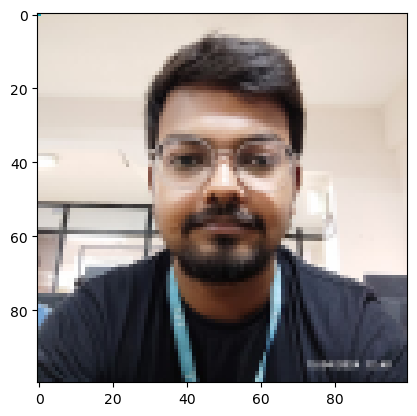

In [44]:
LogisticDecryption(image_path,key_logistic)
im = Image.open(image_path.split('.')[0]+"_LogisticDec.png", 'r')
imshow(np.asarray(im),cmap='gray')